In [ ]:
!nvidia-smi

Fri Apr 14 18:35:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |   5945MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install plotly -q

In [3]:
!git clone https://github.com/openai/point-e

fatal: destination path 'point-e' already exists and is not an empty directory.


In [4]:
%cd point-e

/content/point-e


In [5]:
! pip install -e . -q

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


Imports

In [6]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

Models

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [8]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [9]:
!pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing whole dataset way 1

In [ ]:
from google.colab import files
import cv2
uploaded = files.upload()

Saving B_ROI 54.png to B_ROI 54.png


In [ ]:
!unzip "/content/point-e/datasets.zip" -d "/content/point-e/datasets/"

In [ ]:
!rm datasets.zip #deleting zip after unzip

In [ ]:
import os
dataset_directory_path = '/content/point-e/datasets/Benign ROI'
dataset_file_list_raw = os.listdir(dataset_directory_path)

In [ ]:
dataset_file_list_raw

In [ ]:
img_names = []
dataset_file_list = []
for img_name in dataset_file_list_raw:
  if '.png' in img_name:
    dataset_file_list.append(img_name)
    name = img_name.replace('.png','')
    img_names.append(name)

In [ ]:
dataset_file_list

In [ ]:
img_names

In [ ]:
!pip install open3d


In [ ]:
import plotly.graph_objects as go
from point_e.util.pc_to_mesh import marching_cubes_mesh
import skimage.measure as measure

In [ ]:
path = '/content/point-e/datasets/Benign ROI/' + dataset_file_list[2]
img = Image.open(path)
img

In [ ]:
for i in range(0,len(dataset_file_list)):
  path = '/content/point-e/datasets/Benign ROI/' + dataset_file_list[i]
  img = Image.open(path)
  samples = None
  for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x
  
  pc = sampler.output_to_point_clouds(samples)[0]

  fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))


  #if you need to print 3d model of each dataset then remove comment

  # fig_plotly = go.Figure(
  #       data=[
  #           go.Scatter3d(
  #               x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2], 
  #               mode='markers',
  #               marker=go.scatter.Marker(
  #                 size=2,
  #                 color=40,
  #                 opacity=0.6,
  #                 colorscale="Viridis"
  #             )
  #           )
  #       ],
  #       layout=dict(
  #           scene=dict(
  #               xaxis=dict(visible=False),
  #               yaxis=dict(visible=False),
  #               zaxis=dict(visible=False)
  #           )
  #       ),
  #   )
 
  # fig_plotly.show(renderer="colab")

  # fig_plotly.write_image("images/fig1.png") for export 
  # for more example visit : https://plotly.com/python/static-image-export/


  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  print('creating SDF model...')
  name = 'sdf'
  model = model_from_config(MODEL_CONFIGS[name], device)
  model.eval()

  print('loading SDF model...')
  model.load_state_dict(load_checkpoint(name, device))

  mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=32, # increase to 128 for resolution used in evals
    progress=True,
  )

  plyFileName = "/content/point-e/output/model/" + img_names[i] + ".ply"
  with open(plyFileName, 'wb') as f:
    mesh.write_ply(f)

  

Importing whole dataset way 2

In [ ]:
import plotly.graph_objects as go

import open3d as o3d
import numpy as np

In [ ]:
import cv2 as cv
import numpy as np
import cv2
import os
import math
import numpy as np
import cv2
folder = "/content/drive/MyDrive/Breast Ultrasound/Datasets/Breast Ultrasound/Breast ROI/White BG ROI/WBG_Ben_E/WBG_Ben_E1"
k=1
for im in os.listdir(folder):
    path = os.path.join(folder,im)
    img = cv2.imread(path,0)
    
    samples = None
    for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
      samples = x

    pc = sampler.output_to_point_clouds(samples)[0]

    fig_plotly = go.Figure(
            data=[
                go.Scatter3d(
                    x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2], 
                    mode='markers',
                    marker=dict(
                      size=2,
                      color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
                  )
                )
            ],
            layout=dict(
                scene=dict(
                    xaxis=dict(visible=False),
                    yaxis=dict(visible=False),
                    zaxis=dict(visible=False)
                )
            ),
        )

    fig_plotly.show(renderer="colab")

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.array(pc.coords, dtype=np.float32))


    o3d.io.write_point_cloud(os.path.join("/content/drive/MyDrive/Breast Ultrasound/Datasets/US Point cloud", 'Ben_pc'+str(k)+'.ply'),pcd)
    k = k+1
    
print("success")

For Importing one Image at a time

In [15]:
from google.colab import files
import cv2
uploaded = files.upload()

Saving M_ROI 169.png to M_ROI 169.png


In [ ]:
# Load an image to condition on.
img = Image.open('/content/point-e/M_ROI 169.png')

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

0it [00:00, ?it/s]

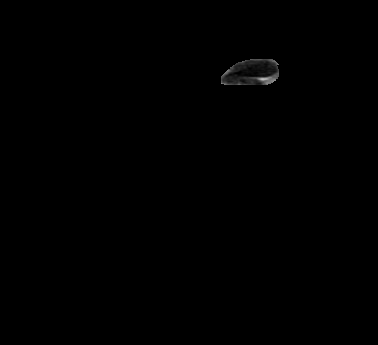

In [ ]:
img

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]

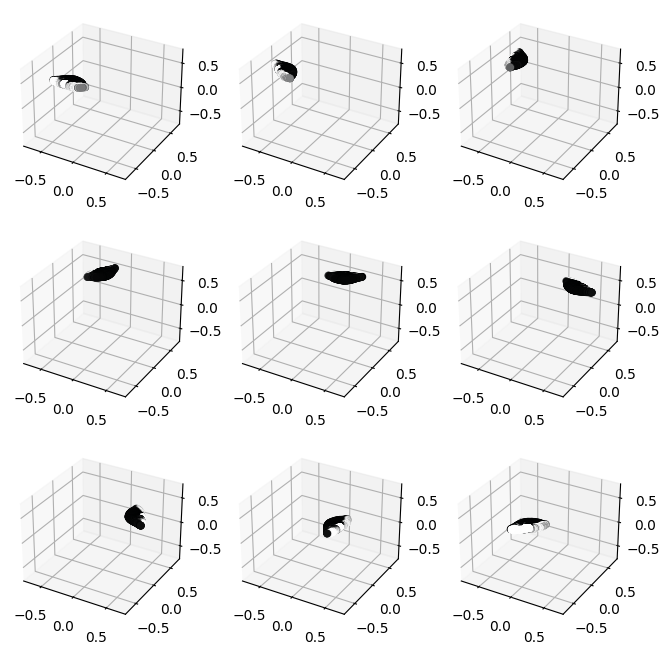

In [ ]:

fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [ ]:
import plotly.graph_objects as go


In [ ]:
fig_plotly = go.Figure(
        data=[
            go.Scatter3d(
                x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2], 
                mode='markers',
                marker=dict(
                  size=2,
                  color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
              )
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        ),
    )

In [ ]:
fig_plotly.show(renderer="colab")

In [ ]:
from point_e.util.pc_to_mesh import marching_cubes_mesh

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating SDF model...
loading SDF model...


<All keys matched successfully>

In [ ]:
import skimage.measure as measure


In [ ]:
# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=32, # increase to 128 for resolution used in evals
    progress=True,
)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# Write the mesh to a PLY file to import into some other program.
with open('B_ROI 46.ply', 'wb') as f:
    mesh.write_ply(f)

In [ ]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import trimesh
import numpy as np

# Load the PLY file into a trimesh object
mesh = trimesh.load('/content/point-e/B_ROI 46.ply')

# Set the color of the mesh
mesh.visual.vertex_colors = np.array([[255, 0, 0, 255]])

# Display the mesh in a window
mesh.show()


ValueError: ignored